# Postprocessing and Model Building

In [1]:
import os
import pickle
import json
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


In [2]:
main_filepath = '/projects/kernlab/akapoor/Demographic_Inference'

CONFIG_FILEPATH = f'{main_filepath}/experiment_config.json'
MODEL_CONFIG_FILEPATH = f'{main_filepath}/model_config.json'

with open(CONFIG_FILEPATH, 'r') as f:
   experiment_config = json.load(f)

with open(MODEL_CONFIG_FILEPATH, 'r') as f:
   model_config = json.load(f)


CWD = os.getcwd()

# Use double quotes for the dictionary keys inside the f-string
EXPERIMENT_DIRECTORY = f"{experiment_config['demographic_model']}_dadi_analysis_{experiment_config['dadi_analysis']}_moments_analysis_{experiment_config['moments_analysis']}_momentsLD_analysis_{experiment_config['momentsLD_analysis']}_seed_{experiment_config['seed']}"
EXPERIMENT_NAME = f'sims_pretrain_{experiment_config["num_sims_pretrain"]}_sims_inference_{experiment_config["num_sims_inference"]}_seed_{experiment_config["seed"]}_num_replicates_{experiment_config["k"]}_top_values_{experiment_config["top_values_k"]}'
SIM_DIRECTORY = f"{EXPERIMENT_DIRECTORY}/sims/{EXPERIMENT_NAME}"

# Check if hidden_size is a list, and if so, join the elements with "_"
hidden_size = model_config['neural_net_hyperparameters']['hidden_size']
if isinstance(hidden_size, list):
    hidden_size_str = "_".join(map(str, hidden_size))  # Join list elements with "_"
else:
    hidden_size_str = str(hidden_size)  # Convert integer to string if not a list

# Build the MODEL_DIRECTORY string
MODEL_DIRECTORY = (
    f"{EXPERIMENT_DIRECTORY}/models/{EXPERIMENT_NAME}/"
    f"num_hidden_neurons_{hidden_size_str}_"
    f"num_hidden_layers_{model_config['neural_net_hyperparameters']['num_layers']}_"
    f"num_epochs_{model_config['neural_net_hyperparameters']['num_epochs']}_"
    f"dropout_value_{model_config['neural_net_hyperparameters']['dropout_rate']}_"
    f"weight_decay_{model_config['neural_net_hyperparameters']['weight_decay']}_"
    f"batch_size_{model_config['neural_net_hyperparameters']['batch_size']}_"
    f"EarlyStopping_{model_config['neural_net_hyperparameters']['EarlyStopping']}"
)


In [3]:
os.chdir('/projects/kernlab/akapoor/Demographic_Inference/')
os.environ['PYTHONPATH'] = '/projects/kernlab/akapoor/Demographic_Inference:' + os.environ.get('PYTHONPATH', '')

In [9]:
with open(os.path.join('/projects/kernlab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'preprocessing_results_obj.pkl'), 'rb') as f:
    preproc = pickle.load(f)

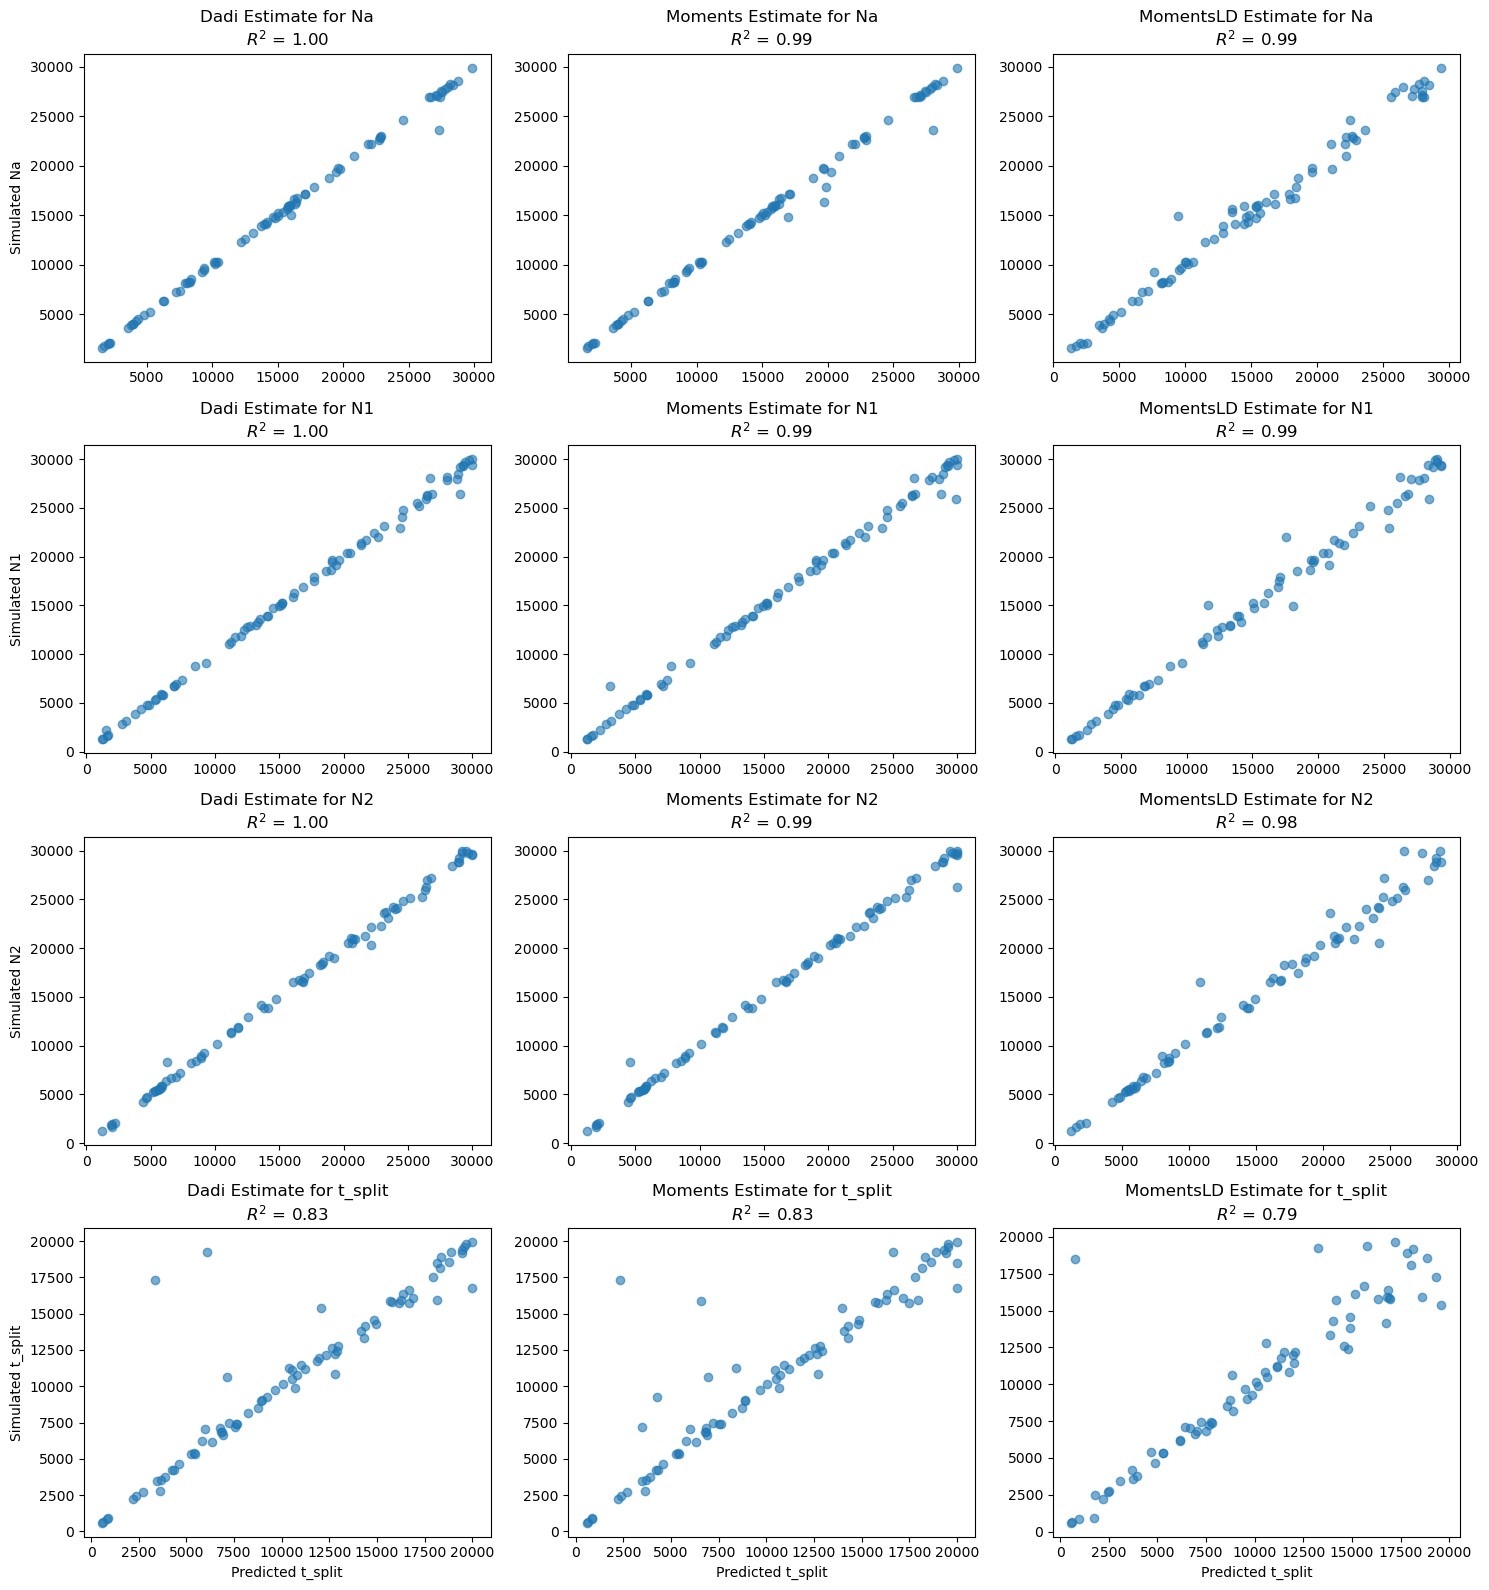

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define the methods and corresponding keys in `post''''`
methods = {
    'Dadi': 'dadi_rep1_{}',
    'Moments': 'moments_rep1_{}',
    'MomentsLD': 'momentsLD_{}'
}

# Define the parameters to plot
parameters = ['Na', 'N1', 'N2', 't_split']

# Load upper and lower bounds from experiment_config
upper_bounds = experiment_config.get('upper_bound_params', {})
lower_bounds = experiment_config.get('lower_bound_params', {})

# Function to filter out values outside parameter bounds
def filter_by_bounds(x, y, param):
    """
    Filters predicted values (x) and target values (y) based on parameter bounds.

    Args:
        x (np.array): Predicted values.
        y (np.array): Target values.
        param (str): Parameter name for looking up bounds.

    Returns:
        Tuple of filtered (x, y) within the bounds.
    """
    lower_bound = lower_bounds.get(param, -np.inf)
    upper_bound = upper_bounds.get(param, np.inf)

    # Mask to keep only values within bounds
    mask = (x >= lower_bound) & (x <= upper_bound) & (y >= lower_bound) & (y <= upper_bound)
    return x[mask], y[mask]

# Create a figure with subplots (one row per parameter, 3 columns for methods)
fig, axes = plt.subplots(len(parameters), 3, figsize=(15, 4 * len(parameters)))

# Loop through parameters and methods to create scatter plots
for row, param in enumerate(parameters):
    target_key = f'simulated_params_{param}'
    if target_key not in preproc['training']['targets']:
        continue  # Skip if parameter is missing

    target_values = np.array(preproc['training']['targets'][target_key])

    for col, (method, pred_template) in enumerate(methods.items()):
        pred_key = pred_template.format(param)  # Format the prediction key
        ax = axes[row, col] if len(parameters) > 1 else axes[col]  # Handle single-row case

        r2 = None  # Default to None

        if pred_key in preproc['training']['predictions']:
            pred_values = np.array(preproc['training']['predictions'][pred_key])

            # Apply bound-based filtering
            pred_values_filtered, target_values_filtered = filter_by_bounds(pred_values, target_values, param)

            # Compute R² score if possible
            if len(pred_values_filtered) > 1 and len(target_values_filtered) > 1:
                r2 = r2_score(target_values_filtered, pred_values_filtered)

            # Scatter plot (filtered data)
            ax.scatter(pred_values_filtered, target_values_filtered, alpha=0.6)

            # Determine appropriate axis limits
            if len(pred_values_filtered) > 0 and len(target_values_filtered) > 0:
                min_pred, max_pred = np.min(pred_values_filtered), np.max(pred_values_filtered)
                min_target, max_target = np.min(target_values_filtered), np.max(target_values_filtered)

                # Expand limits slightly for better visualization
                margin_x = (max_pred - min_pred) * 0.05  # 5% margin
                margin_y = (max_target - min_target) * 0.05  # 5% margin

                ax.set_xlim(min_pred - margin_x, max_pred + margin_x)
                ax.set_ylim(min_target - margin_y, max_target + margin_y)

        # Set title with R²
        if r2 is not None:
            ax.set_title(f"{method} Estimate for {param}\n$R^2$ = {r2:.2f}")
        else:
            ax.set_title(f"{method} Estimate for {param}\n$R^2$ = N/A")

        # Set labels
        if col == 0:
            ax.set_ylabel(f"Simulated {param}")
        if row == len(parameters) - 1:
            ax.set_xlabel(f"Predicted {param}")

# Adjust layout and show the figure
plt.tight_layout()
plt.show()




In [12]:
preproc['training']['predictions'].columns

Index(['dadi_rep1_Na', 'moments_rep1_Na', 'moments_rep1_FIM_element_0',
       'moments_rep1_FIM_element_1', 'moments_rep1_FIM_element_2',
       'moments_rep1_FIM_element_3', 'moments_rep1_FIM_element_4',
       'moments_rep1_FIM_element_5', 'moments_rep1_FIM_element_6',
       'moments_rep1_FIM_element_7', 'moments_rep1_FIM_element_8',
       'moments_rep1_FIM_element_9', 'dadi_rep1_N1', 'moments_rep1_N1',
       'dadi_rep1_N2', 'moments_rep1_N2', 'dadi_rep1_t_split',
       'moments_rep1_t_split', 'dadi_rep1_m', 'moments_rep1_m', 'dadi_rep2_Na',
       'moments_rep2_Na', 'moments_rep2_FIM_element_0',
       'moments_rep2_FIM_element_1', 'moments_rep2_FIM_element_2',
       'moments_rep2_FIM_element_3', 'moments_rep2_FIM_element_4',
       'moments_rep2_FIM_element_5', 'moments_rep2_FIM_element_6',
       'moments_rep2_FIM_element_7', 'moments_rep2_FIM_element_8',
       'moments_rep2_FIM_element_9', 'dadi_rep2_N1', 'moments_rep2_N1',
       'dadi_rep2_N2', 'moments_rep2_N2', 'dadi_r

## Postprocessing

In [13]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/postprocessing.py \
    --config_file $CONFIG_FILEPATH \
    --training_features_filepath $SIM_DIRECTORY/training_features.csv \
    --training_targets_filepath $SIM_DIRECTORY/training_targets.csv \
    --validation_features_filepath $SIM_DIRECTORY/validation_features.csv \
    --validation_targets_filepath $SIM_DIRECTORY/validation_targets.csv \
    --sim_directory $SIM_DIRECTORY



Processing training data:
Removed 15 outliers from training set.
===> Normalizing the data.

Processing validation data:
Removed 4 outliers from validation set.
===> Normalizing the data.
Postprocessing dict keys: dict_keys(['normalization', 'predictions', 'normalized_predictions', 'targets', 'normalized_targets'])
Postprocessing complete!


In [14]:
with open(os.path.join('/projects/kernlab/akapoor/Demographic_Inference',f'{SIM_DIRECTORY}', 'postprocessing_results.pkl'), 'rb') as f:
    post = pickle.load(f)

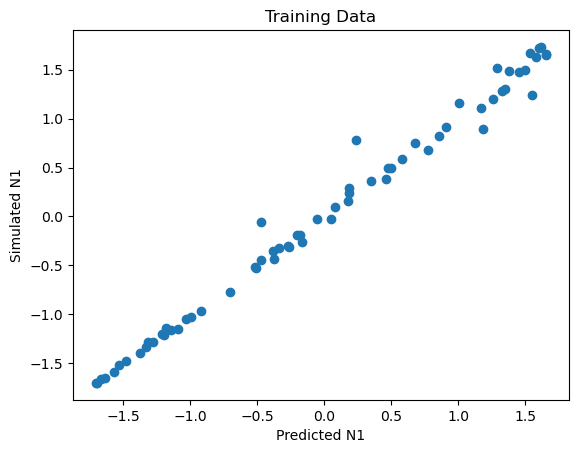

In [15]:
plt.figure()
plt.scatter(post['training']['normalized_predictions']['momentsLD_N1'], post['training']['normalized_targets']['simulated_params_N1'])
plt.xlabel('Predicted N1')
plt.ylabel('Simulated N1')
plt.title('Training Data')
plt.show()

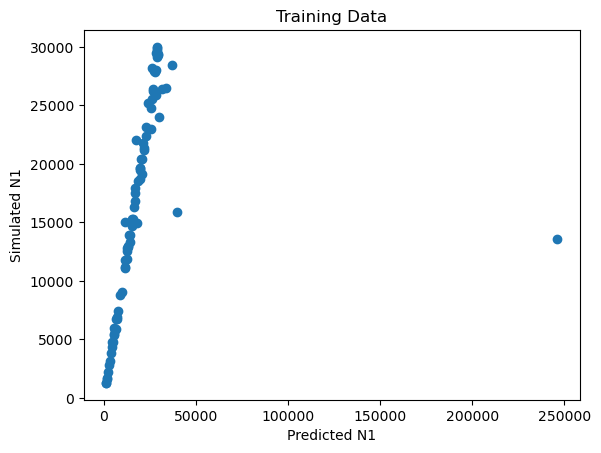

In [16]:
plt.figure()
plt.scatter(preproc['training']['predictions']['momentsLD_N1'], preproc['training']['targets']['simulated_params_N1'])
plt.xlabel('Predicted N1')
plt.ylabel('Simulated N1')
plt.title('Training Data')
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def compute_and_plot_mse(post, parameters, methods):
    """
    post: The dictionary with keys like post['training']['normalized_predictions'] etc.
    parameters: list of parameters, e.g. ['Na', 'N1', 'N2', 't_split']
    methods: list of methods, e.g. ['moments', 'dadi', 'momentsLD']

    Returns:
        A dictionary:
        {
          "training_mse": {
             "moments":  {param: mse, ...},
             "dadi":     {param: mse, ...},
             "momentsLD":{param: mse, ...},
          },
          "validation_mse": { ... },
        }
    And also creates two bar charts (training + validation) with error bars (SEM).
    """

    # We'll store final MSE in this dict:
    final_mse_dict = {
        "training_mse": {method: {} for method in methods},
        "validation_mse": {method: {} for method in methods},
    }

    # For convenience, define a small helper to compute MSE+SEM for a given stage
    def compute_mse_sem_for_stage(stage):
        """
        stage is 'training' or 'validation'.
        Returns two dicts: {param: {method: mse}}, {param: {method: sem}}
        """
        mse_values = {param: {} for param in parameters}
        sem_values = {param: {} for param in parameters}

        # We'll assume post[stage]['targets'] and post[stage]['normalized_targets']
        # store the "true" values under 'simulated_params_{param}',
        # and post[stage]['normalized_predictions'] for predictions.
        # If any param is missing, we skip.
        for param in parameters:
            target_key = f'simulated_params_{param}'
            # Check if the param is present
            if target_key not in post[stage]['targets']:
                # skip if param is missing
                continue

            # "true" values
            target_values = np.array(post[stage]['normalized_targets'][target_key])

            for method in methods:
                # For "momentsLD", no rep1_; for others, we do method_rep1_param
                if method == 'momentsLD':
                    pred_key = f'momentsLD_{param}'
                else:
                    pred_key = f'{method}_rep1_{param}'

                if pred_key in post[stage]['normalized_predictions']:
                    pred_values = np.array(post[stage]['normalized_predictions'][pred_key])
                    # compute squared residuals
                    residuals_sq = (pred_values - target_values) ** 2

                    mse = residuals_sq.mean()
                    std_res = residuals_sq.std(ddof=1)  # sample std
                    n = len(residuals_sq)
                    sem = std_res / np.sqrt(n) if n > 1 else 0.0

                    mse_values[param][method] = mse
                    sem_values[param][method] = sem
                else:
                    mse_values[param][method] = None
                    sem_values[param][method] = None

        return mse_values, sem_values

    # We'll also define a helper to plot a bar chart
    def plot_bar_chart(mse_values, sem_values, stage):
        """
        Creates a bar chart for MSE ± SEM given by mse_values/sem_values dicts:
          mse_values = {param: {method: float or None}}
          sem_values = {param: {method: float or None}}
        stage: e.g. "training" or "validation"
        """
        x_labels = list(mse_values.keys())  # e.g. ['Na','N1','N2','t_split']
        x = np.arange(len(x_labels))
        width = 0.25

        fig, ax = plt.subplots(figsize=(10, 5))
        colors = {'moments': 'tab:blue', 'dadi': 'tab:orange', 'momentsLD': 'tab:green'}

        for i, method in enumerate(methods):
            # Build MSE + SEM arrays in the correct param order
            mse_list = []
            sem_list = []
            for param in x_labels:
                # If we never computed it, default to 0
                mse_val = mse_values[param].get(method, None)
                sem_val = sem_values[param].get(method, None)

                if mse_val is None:
                    mse_val = 0
                    sem_val = 0
                mse_list.append(mse_val)
                sem_list.append(sem_val)

            ax.bar(
                x + i * width,
                mse_list,
                width,
                label=method.capitalize(),
                color=colors[method],
                yerr=sem_list,  # error bars
                capsize=4
            )

        ax.set_xlabel('Parameter')
        ax.set_ylabel('MSE (± SEM)')
        ax.set_title(f'MSE by Parameter and Method ({stage.capitalize()} set)')
        ax.set_xticks(x + width)
        ax.set_xticklabels(x_labels)
        ax.legend()
        plt.show()

    # Compute for training
    train_mse_values, train_sem_values = compute_mse_sem_for_stage('training')
    # Plot training
    plot_bar_chart(train_mse_values, train_sem_values, 'training')

    # Convert train_mse_values to the final dictionary format
    # final_mse_dict["training_mse"][method][param] = MSE
    # We'll fill it method by method, param by param.
    for param in train_mse_values:
        for method in train_mse_values[param]:
            val = train_mse_values[param][method]
            if val is not None:
                # create if not exist
                final_mse_dict["training_mse"][method][param] = val
            else:
                final_mse_dict["training_mse"][method][param] = None

    # Compute for validation
    val_mse_values, val_sem_values = compute_mse_sem_for_stage('validation')
    # Plot validation
    plot_bar_chart(val_mse_values, val_sem_values, 'validation')

    # Convert val_mse_values to final dictionary format
    for param in val_mse_values:
        for method in val_mse_values[param]:
            val = val_mse_values[param][method]
            if val is not None:
                final_mse_dict["validation_mse"][method][param] = val
            else:
                final_mse_dict["validation_mse"][method][param] = None

    return final_mse_dict


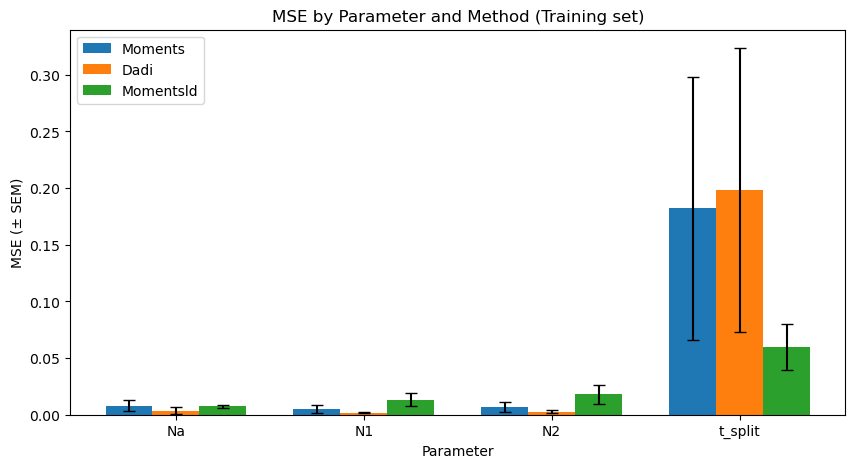

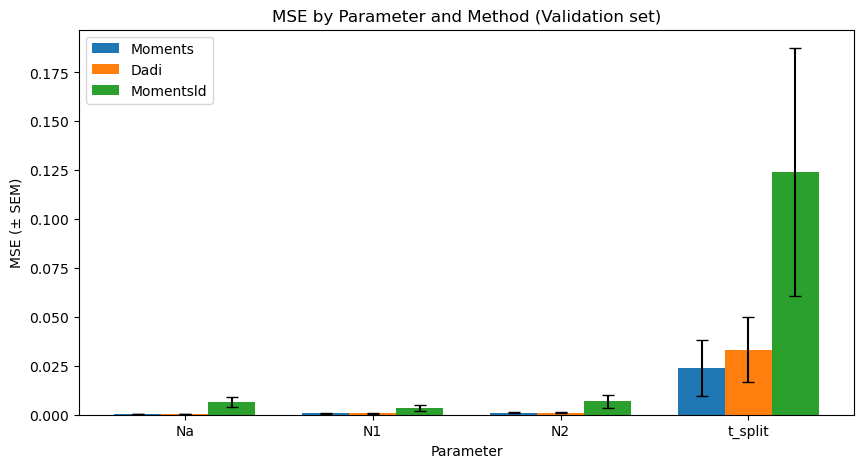

In [18]:
parameters = ['Na', 'N1', 'N2', 't_split']
methods = ['moments', 'dadi', 'momentsLD']

mse_dict = compute_and_plot_mse(post, parameters, methods)

In [19]:
mse_dict

{'training_mse': {'moments': {'Na': 0.00799300005879586,
   'N1': 0.005024242866365116,
   'N2': 0.0068468134027959895,
   't_split': 0.18206271266775165},
  'dadi': {'Na': 0.0034848849409648817,
   'N1': 0.0017834702251401256,
   'N2': 0.0024776649948800348,
   't_split': 0.19822462763232404},
  'momentsLD': {'Na': 0.007173069822648277,
   'N1': 0.013269802625157158,
   'N2': 0.018038912973542133,
   't_split': 0.05948139494053701}},
 'validation_mse': {'moments': {'Na': 0.0002820442525976283,
   'N1': 0.0007355914439933107,
   'N2': 0.0010034491176387599,
   't_split': 0.02374804418897051},
  'dadi': {'Na': 0.00028427610971457724,
   'N1': 0.0007194084835415455,
   'N2': 0.0010223981019718427,
   't_split': 0.03323528295244983},
  'momentsLD': {'Na': 0.006437697631264242,
   'N1': 0.0034184279374796737,
   'N2': 0.006723743204153783,
   't_split': 0.12409070908517036}}}

In [20]:
mse_dict['validation_mse']['dadi']

{'Na': 0.00028427610971457724,
 'N1': 0.0007194084835415455,
 'N2': 0.0010223981019718427,
 't_split': 0.03323528295244983}

## Extracting Features

In [21]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/extracting_features.py \
 --postprocessing_results_filepath $SIM_DIRECTORY/postprocessing_results.pkl \
 --sim_directory $SIM_DIRECTORY

dict_keys(['parameter_names', 'target_names', 'training', 'validation'])
Training features shape: (65, 45)
Validation features shape: (16, 45)
Training targets shape: (65, 5)
Validation targets shape: (16, 5)


## Linear Evaluation

In [22]:
with open('/projects/kernlab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_295/sims/sims_pretrain_100_sims_inference_1_seed_295_num_replicates_3_top_values_2/features_and_targets.pkl', 'rb') as f:
    features_targets = pickle.load(f)

In [23]:
features_targets['training']['features']


,dadi_rep1_Na,moments_rep1_Na,moments_rep1_FIM_element_0,moments_rep1_FIM_element_1,moments_rep1_FIM_element_2,moments_rep1_FIM_element_3,moments_rep1_FIM_element_4,moments_rep1_FIM_element_5,moments_rep1_FIM_element_6,moments_rep1_FIM_element_7,...,moments_rep2_N2,dadi_rep2_t_split,moments_rep2_t_split,dadi_rep2_m,moments_rep2_m,momentsLD_Na,momentsLD_N1,momentsLD_N2,momentsLD_t_split,momentsLD_m
0,3613.067647,3616.424098,0.390846,-0.252878,-0.605670,0.111752,0.391215,-0.467033,0.127364,0.310880,...,25202.384728,16371.667203,16333.976698,0.000058,0.000058,3659.965554,25299.758896,25478.530578,16863.695473,0.000059
1,27334.464289,26939.729048,0.401090,-1.101061,0.154493,0.113292,0.327276,0.027316,0.117643,0.251096,...,16722.484168,14555.550154,14588.370822,0.000100,0.000100,27894.862709,23940.767074,16022.940514,19602.323817,0.000101
2,22787.909194,22775.745690,0.329943,1.142001,-0.213399,0.097117,0.382542,-0.333205,0.101229,0.227474,...,19238.749766,8900.667754,8882.219862,0.000012,0.000012,22711.548212,15070.373602,18709.728394,8756.425432,0.000012
3,19610.834166,19617.548258,-0.339509,6.653322,1.243466,0.074820,0.314054,0.015037,0.070798,0.016833,...,8883.931497,3894.761721,3889.506229,0.000011,0.000011,19569.134908,4803.782160,8480.195388,3932.599853,0.000014
4,28161.264633,28169.406437,0.182165,-0.355259,0.312804,0.098933,0.355136,-0.131032,0.122795,0.284033,...,24577.294847,18309.514533,18215.280375,0.000022,0.000022,27712.520611,13982.870195,25133.652061,18029.057677,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2096.956744,2100.093519,0.054848,-0.024256,-0.439423,0.092545,0.401937,-0.465039,0.113648,0.308491,...,23914.306440,9660.378871,9654.965448,0.000002,0.000002,2053.212532,5353.909744,23207.231945,9516.663757,0.000001
61,10159.812042,10140.985106,0.393362,1.125830,-0.353916,0.094735,0.041293,-0.194427,0.042402,0.258420,...,5835.480844,6910.548303,6891.339483,0.000004,0.000004,10036.110053,17062.023830,6076.056801,6944.596529,0.000005
62,22901.311314,22909.816119,0.326111,-0.080485,-0.098834,0.105107,0.393468,-0.274946,0.126570,0.275952,...,28993.583678,15800.097434,15723.788292,0.000035,0.000035,22592.867082,19342.587634,28394.438238,16982.830429,0.000037
63,8092.460589,8104.709122,0.418795,0.006742,-0.582879,0.100421,0.400363,-0.445821,0.098200,0.257534,...,22762.931974,6877.587516,6848.434961,0.000003,0.000003,8192.501179,27678.682193,22675.354428,7048.011138,0.000008


In [26]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type standard

Model directory created/verified: split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_295/models/sims_pretrain_100_sims_inference_1_seed_295_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
Initializing LinearRegression with kwargs={}
PREDICTIONS SHAPE TRAINING: (65, 5)
[2.04156268e-04 1.01126002e-06 1.40715339e-03 6.49025926e-04
 3.16278054e-04 1.29965911e-03 3.29129286e-04 1.94210319e-06
 1.02788878e-04 1.82717939e-05 3.00382151e-04 4.38921740e-03
 6.06040322e-04 1.82432960e-03 1.17261108e-04 2.52660594e-04
 2.17370734e-04 2.00347417e-04 3.01514967e-08 3.76278338e-04
 1.66806366e-04 1.41194707e-04 1.26820520e-04 1.58844809e-03
 5.52931592e-06 8.66163326e-04 2.39495801e-04 2.05619842e-05
 6.01860156e-04 4.66582778e-04 1.13693660e-05 4.95278267e-03
 7.53850982e-04 6.81086418e-10 1.23112494e-04 9.97779543e-14
 3.30520585e-04 4.08724949e-04 1.0270

### Ridge

In [27]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type ridge

Model directory created/verified: split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_295/models/sims_pretrain_100_sims_inference_1_seed_295_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
Best parameters for ridge: {'alpha': 100.0}
Initializing Ridge with kwargs={'alpha': 100.0}
PREDICTIONS SHAPE TRAINING: (65, 5)
[9.21368837e-04 8.64805475e-05 1.52837803e-03 1.03985962e-04
 9.16323047e-04 7.59761111e-05 1.76112650e-03 2.42061326e-03
 4.76509258e-03 9.06716642e-05 5.47262097e-04 5.67745715e-04
 1.11127370e-04 1.97020630e-03 1.74380448e-03 8.31853487e-04
 4.69101827e-04 2.68790637e-04 6.00115869e-05 1.14663778e-04
 2.45684233e-03 3.17963079e-04 1.44330916e-03 6.08441412e-03
 7.96976539e-05 1.63580744e-03 9.66213048e-05 3.80143194e-04
 3.02707341e-03 1.11117249e-04 1.60880734e-03 1.79337217e-02
 2.32374145e-04 4.44326687e-04 6.65307704e-04 4.422

### Lasso

In [28]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type lasso

Model directory created/verified: split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_295/models/sims_pretrain_100_sims_inference_1_seed_295_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e-02, tolerance: 5.998e-03
  model = cd_fast.enet_coordinate_descent(
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

### Elastic Net

In [29]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/linear_evaluation.py \
     --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
     --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
     --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
     --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
     --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json \
     --regression_type elasticnet

Model directory created/verified: split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_295/models/sims_pretrain_100_sims_inference_1_seed_295_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-02, tolerance: 5.998e-03
  model = cd_fast.enet_coordinate_descent(
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

## Random Forest

In [30]:
!python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/random_forest_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_295/models/sims_pretrain_100_sims_inference_1_seed_295_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No hyperparameters specified. Running RandomizedSearchCV to find best hyperparameters...

Fitting 3 folds for each of 10 candidates, totalling 30 fits
/gpfs/home/akapoor/miniforge3/envs/snakemake-env/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,

Best hyperparameters found via RandomizedSearchCV: {'random_state': 2023, 'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 30}

Initializing RandomForestRegressor with kwargs={'n_estimators': 50, 'max_depth': 30, 'random_state': 2023, 'min_samples_split': 5}

Random Forest predictions shape (training): (6

## XGBoost

In [32]:
 !python /projects/kernlab/akapoor/Demographic_Inference/snakemake_scripts/xgboost_evaluation.py \
    --features_and_targets_filepath $SIM_DIRECTORY/features_and_targets.pkl \
    --model_config_path /projects/kernlab/akapoor/Demographic_Inference/model_config.json \
    --color_shades_file $SIM_DIRECTORY/color_shades.pkl \
    --main_colors_file $SIM_DIRECTORY/main_colors.pkl \
    --experiment_config_filepath /projects/kernlab/akapoor/Demographic_Inference/experiment_config.json

Model directory created/verified: split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_295/models/sims_pretrain_100_sims_inference_1_seed_295_num_replicates_3_top_values_2/num_hidden_neurons_10_num_hidden_layers_2_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_64_EarlyStopping_False

No XGBoost hyperparameters specified. Running RandomizedSearchCV...

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found via RandomizedSearchCV: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Initializing XGBRegressor with kwargs={'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 3, 'reg_lambda': 1, 'reg_alpha': 0}

XGBoost predictions shape (training): (65, 5)
XGBoost predictions shape (validation): (16, 5)

[1.03795723e-07 3.91212391e-08 

## Neural Network

In [ ]:
    # parser.add_argument("--experiment_directory", type=str, required=True)
    # parser.add_argument("--model_config_file", type=str, required=True)
    # parser.add_argument("--features_file", type=str, required=True)
    # parser.add_argument("--color_shades", type=str, required=True)
    # parser.add_argument("--main_colors", type=str, required=True)

In [ ]:
preproc['training']['predictions']

In [ ]:
!python /sietch_colab/akapoor/Demographic_Inference/snakemake_scripts/setup_trainer.py \
    --experiment_directory $EXPERIMENT_DIRECTORY \
    --model_config_file $MODEL_CONFIG_FILEPATH \
    --features_file $SIM_DIRECTORY/features_and_targets.pkl \
    --color_shades $SIM_DIRECTORY/color_shades.pkl \
    --main_colors $SIM_DIRECTORY/main_colors.pkl

In [ ]:
preproc['training']['predictions'].columns

In [ ]:
import torch
print("Is CUDA available?", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")